In [76]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
from sympy import Matrix, symbols, simplify
import sympy as sp
from scipy.integrate import odeint

# HOVERING PARTICLE

In [77]:
m = 1.

A = np.array(
    [
        [0., 1.],
        [0., 0.]
    ]
)

B = np.array(
    [
        [0.],
        [1/m]
    ]
)

C = np.array([
    1., 0.
])

In [78]:
Q = np.array(
    [
        [10, 0],
        [0, 1]
    ]
)

R = 1

K, _, _ = ct.lqr(A, B, Q, R)

In [79]:
T = np.arange(0,10,0.001)

In [80]:
def particle_EOM(y, t, pert):
    y = np.reshape((4,1))
    

In [81]:
z0 = np.array([
    [1],
    [0]
])
B*K*z0

array([[0., 0.],
       [0., 0.]])

# HOVERING LINE

## DEFINITIONS

In [82]:
def create_base_system(mass, length, q_params, r_params):
    Icm = mass*(length**2)/12
    
    A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
    ])

    B = np.array(
        [
            [0, 0],
            [0, 0],
            [1/mass, 1/mass],
            [length/(2*Icm), -length/(2*Icm)]
        ]
    )

    C = np.array(
        [
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ]
    )

    D = 0
    
    Q = q_params
    R = r_params
    
    K, _, _ = ct.lqr(A, B, Q, R)
    
    return ct.ss(A, B, C, D, inputs=['F1', 'F2'],
            states=['z', 'theta', 'zDot', 'thetaDot'],
            outputs=['z', 'theta']), K

In [83]:
s = symbols('s')
I, M, l = symbols('I,M,l')
K11, K12, K13, K14, K21, K22, K23, K24 = symbols('K11,K12,K13,K14,K21,K22,K23,K24')

In [84]:
Icm = 5./12.
values = {M:5., I:Icm, l:1.}

In [85]:
def create_perturbed_system(K, mag, loc, phys_params, z_eq):
    AA = Matrix(
        [
            [0, 0, 1, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0],
            [0, 0, 0, 0]
        ]
    )

    BB = Matrix(
        [
            [0, 0],
            [0, 0],
            [1/M, 1/M],
            [l/(2*I), -l/(2*I)]
        ]
    )

    CC = Matrix(
        [
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ]
    )

    KK = Matrix(
        [
            [K11, K12, K13, K14],
            [K21, K22, K23, K24]
        ]
    )

    Gsymb = simplify(
        CC*(s*Matrix.eye(4) - AA + BB*KK)**-1
    )
    
    F = Matrix(
        [
            [0],
            [0],
            [mag],
            [mag*loc]
        ]
    )
    
    x_eq = Matrix(
        [
            [z_eq],
            [0],
            [0],
            [0]
        ]
    )
    
    gain_dict = {K11:K[0,0], K12:K[0,1], K13:K[0,2], K14:K[0,3], K21:K[1,0], K22:K[1,1], K23:K[1,2], K24:K[1,3]}
    
    T1 = simplify(simplify(Gsymb*F).subs(phys_params).subs(gain_dict))
    T0 = simplify(simplify(Gsymb*BB*KK*x_eq).subs(phys_params).subs(gain_dict))
    
    T1x_numer = sp.Poly(sp.collect(sp.expand(sp.numer(T1[0,0])),s),s).all_coeffs()
    T1_denom = sp.Poly(sp.collect(sp.expand(sp.denom(T1[0,0])),s),s).all_coeffs()
    T1theta_numer = sp.Poly(sp.collect(sp.expand(sp.numer(T1[1,0])),s),s).all_coeffs()
    
    T1x_coeffs = list(np.array(T1x_numer, dtype=np.float64))
    denom_coeffs1 = list(np.array(T1_denom, dtype=np.float64))
    T1theta_coeffs = list(np.array(T1theta_numer, dtype=np.float64))
    
    T0x_numer = sp.Poly(sp.collect(sp.expand(sp.numer(T0[0,0])),s),s).all_coeffs()
    T0_denom = sp.Poly(sp.collect(sp.expand(sp.denom(T0[0,0])),s),s).all_coeffs()
    T0theta_numer = sp.Poly(sp.collect(sp.expand(sp.numer(T0[1,0])),s),s).all_coeffs()
    
    T0x_coeffs = list(np.array(T0x_numer, dtype=np.float64))
    denom_coeffs0 = list(np.array(T0_denom, dtype=np.float64))
    T0theta_coeffs = list(np.array(T0theta_numer, dtype=np.float64))
    
    return ct.tf([[T1x_coeffs], [T1theta_coeffs]], denom_coeffs1,
                       inputs = 'Disturbance',
                       outputs=['delta z', 'delta theta']), ct.tf([[T0x_coeffs], [T0theta_coeffs]], denom_coeffs0,
                       inputs = 'Eqlb state',
                       outputs=['delta z', 'delta theta'])

In [86]:
def create_costFunction_params(z_max=1., zDot_max=0.1, theta_max=0.1, thetaDot_max=0.1, alpha=1., beta=1., F_max=1.):
    return np.array(
        [
            [(alpha**2)/(z_max**2), 0, alpha/(z_max*zDot_max), 0],
            [0, (beta**2)/(theta_max**2), 0, beta/(theta_max*thetaDot_max)],
            [alpha/(z_max*zDot_max), 0, 1/(zDot_max**2), 0],
            [0, beta/(theta_max*thetaDot_max), 0, 1/(thetaDot_max**2)]
        ]
    ), np.array(
        [
            [1/(F_max**2), 0],
            [0, 1/(F_max**2)]
        ]
    )

In [87]:
q_params, r_params = create_costFunction_params(zDot_max = 100., alpha=10.)
_, K = create_base_system(5., 1., q_params, r_params)

In [88]:
pert_sys1, pert_sys0 = create_perturbed_system(K, -0.1, 0.5, values, z_eq=1.)

In [89]:
T = np.arange(0, 10, 0.05)

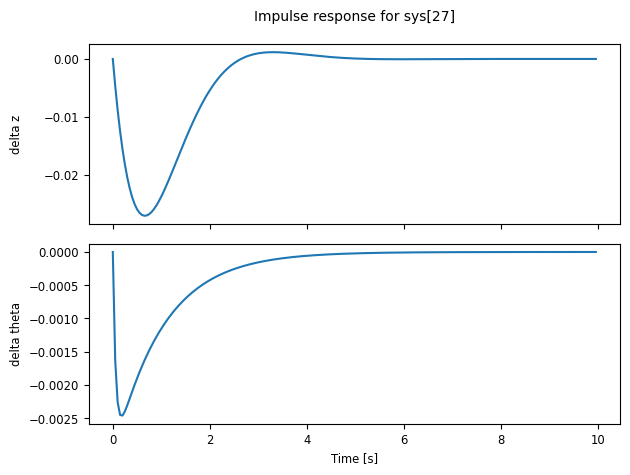

In [90]:
ct.impulse_response(pert_sys1, T).plot()

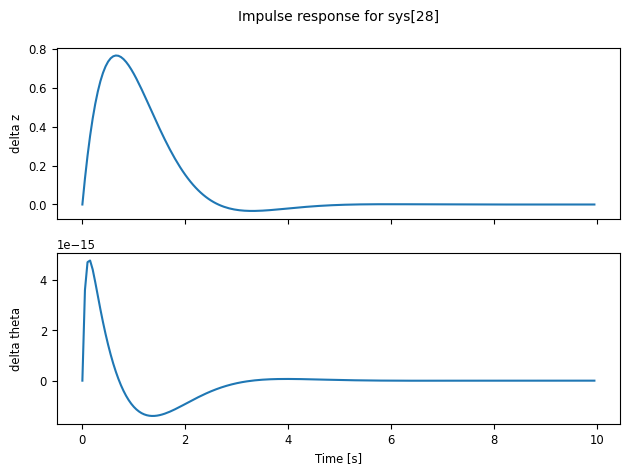

In [91]:
ct.impulse_response(pert_sys0, T).plot()

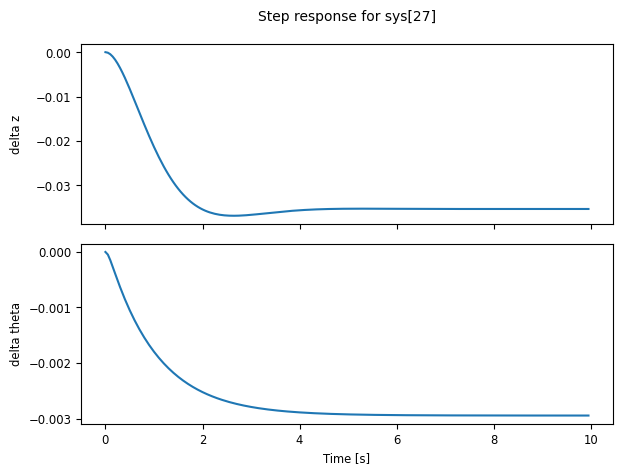

In [92]:
ct.step_response(pert_sys1, T).plot()

/Users/ashtonlowenstein/Desktop/VS Code/.conda/lib/python3.11/site-packages/control/timeresp.py:1463: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


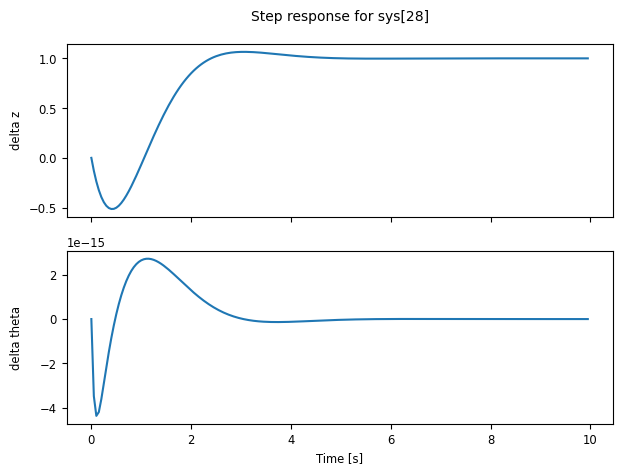

In [93]:
ct.step_response(pert_sys0, T, initial_state=[1.,0.,0.,0.]).plot()

## DISTURBANCE REJECTION

In [94]:
M = 1.
l = 5.
Icm = M*(l**2)/12

In [95]:
q_params, r_params = create_costFunction_params(zDot_max = 10., alpha=1000., beta=1000.)
base_sys, K = create_base_system(M, l, q_params, r_params)
A = base_sys.A
B = base_sys.B
C = base_sys.C

In [96]:
def observer_gain(sys, q_params, r_params):
    A = sys.A
    B = sys.B
    C = sys.C
    D = sys.D
    
    dual_sys = ct.ss(A.T, C.T, B.T, D.T)
    
    L, _, _ = ct.lqr(dual_sys, q_params, r_params)
    
    return L

In [97]:
L=observer_gain(base_sys, 10000*np.eye(4), np.eye(2)).T

In [98]:
Cd = np.array(
    [
        [0, 0, 1, 1],
        [0, 0, 1, -1]
    ]
)

In [99]:
A_ref = np.block(
    [
        [A - np.matmul(B,K), np.matmul(B,K)],
        [np.zeros((4,4)), A - np.matmul(L,C)]
    ]
)

In [100]:
def bigODE(y, t, A):
    x = np.array(y).reshape((16,1))
    rhs = np.matmul(A,x)
    
    dydt = rhs.reshape((16,))
    return dydt

In [101]:
def littleODE(y,t,A,kr,ref,dist, t0, t1=100):
    
    def Heaviside(t, t0):
        if t-t0>=0:
            return 1.
        else:
            return 0.
    
    x = np.array(y).reshape((8,1))
    
    reference = np.concatenate([np.matmul(np.matmul(B,kr),ref),np.zeros((4,1))], axis=0)
    
    disturbance = np.concatenate([dist, dist], axis=0)
    
    rhs = np.matmul(A,x) + reference + (Heaviside(t,t0)-Heaviside(t,t1)) * disturbance
    
    dydt = rhs.reshape((8,))
    
    return dydt

In [102]:
k_r = -np.linalg.inv(
    np.matmul(np.matmul(C,
              np.linalg.inv(
                  A - np.matmul(B,K)
              )), B)
)

In [103]:
def initial_condition(z0):
    return [z0, 0, 0, 0, z0, 0, 0, 0]

def perturbation(mag, loc, M, I):
    return np.array([[0], [0], [-mag/M],[-mag*loc/I]])

In [104]:
dt = 0.001
T = np.arange(0, 15, dt)

In [105]:
sol2 = odeint(littleODE, 
              initial_condition(0.),
              T,
              args=(A_ref, 
                    k_r, 
                    np.array([[initial_condition(0.)[0]],[initial_condition(0.)[1]]]),
                    perturbation(M/10, l/5, M, Icm),
                    1.,
                    5.
                )
)

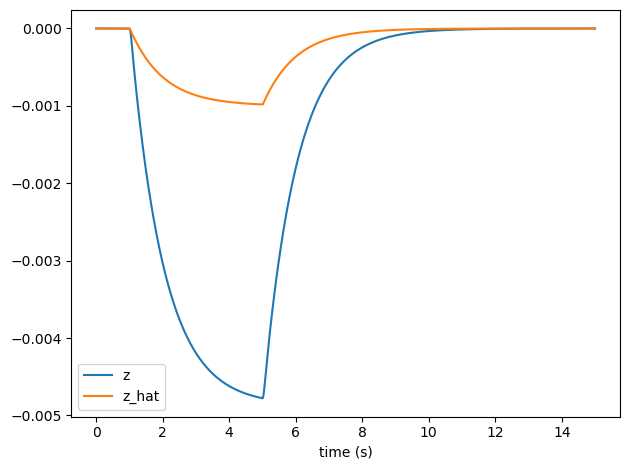

In [106]:
plt.plot(T,sol2[:,0], label='z')
plt.plot(T, sol2[:,4], label = 'z_hat')
#plt.vlines(1,ymin=0.9992, ymax=1.00005, color='r', linestyles='dashed')
plt.xlabel('time (s)')
plt.tight_layout()
plt.legend()
plt.show()

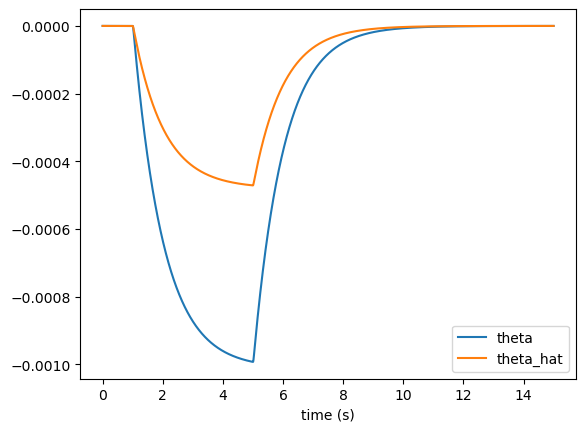

In [107]:
plt.plot(T, sol2[:,1], label='theta')
plt.plot(T, sol2[:,5], label='theta_hat')
plt.xlabel('time (s)')
plt.legend()
plt.show()


# HOVERING PLANE

In [108]:
M = 5.
w = 5.
l = 5.
Ix = M*(w**2)/12
Iy = M*(l**2)/12

In [109]:
A = np.block(
    [
        [np.zeros((3,3)), np.eye(3)],
        [np.zeros((3,3)), np.zeros((3,3))]
    ]
)

B = np.array(
    [
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1/M, 1/M, 1/M, 1/M],
        [0, l/(2*Ix), 0, -l/(2*Ix)],
        [-w/(2*Iy), 0, w/(2*Iy), 0]
    ]
)

C = np.eye(6)

D=0

In [110]:
def create_plane_system(mass, length, width, q_params, r_params):
    
    Ix = mass*(length**2)/12
    Iy = mass*(width**2)/12
    
    A = np.block(
        [
            [np.zeros((3,3)), np.eye(3)],
            [np.zeros((3,3)), np.zeros((3,3))]
        ]
    )

    B = np.array(
        [
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [1/mass, 1/mass, 1/mass, 1/mass],
            [0, length/(2*Ix), 0, -length/(2*Ix)],
            [-width/(2*Iy), 0, width/(2*Iy), 0]
        ]
    )

    C = np.eye(6)

    D=0
    
    Q = q_params
    R = r_params
    
    K, _, _ = ct.lqr(A, B, Q, R)
    
    return ct.ss(A, B, C, D), K

In [111]:
def create_plane_costFunction_params(z_max=1., zDot_max=0.1, phi_max = 0.1, phiDot_max = 0.1, theta_max=0.1, thetaDot_max=0.1, alpha=1., beta=1., gamma = 1., F_max=1.):
    return np.array(
        [
            [(alpha**2)/(z_max**2), 0, 0, alpha/(z_max*zDot_max), 0, 0],
            [0, (gamma**2)/(phi_max**2), 0, 0, gamma/(phi_max*phiDot_max), 0],
            [0, 0, (beta**2)/(theta_max**2), 0, 0, beta/(theta_max*thetaDot_max)],
            [alpha/(z_max*zDot_max), 0, 0, 1/(zDot_max**2), 0, 0],
            [0, gamma/(phi_max*phiDot_max), 0, 0, 1/(phiDot_max**2), 0],
            [0, 0, beta/(theta_max*thetaDot_max), 0, 0, 1/(thetaDot_max**2)]
        ]
    ), (1/F_max**2)*np.eye(4)

In [112]:
q_params, r_params = create_plane_costFunction_params(zDot_max = 100., alpha=100., gamma = 100., beta = 100., phiDot_max=0.01, thetaDot_max=0.01)
plane_sys, K = create_plane_system(M, l, w, q_params, r_params)

In [113]:
A = plane_sys.A
B = plane_sys.B
C = plane_sys.C

L = observer_gain(plane_sys, 1500.*np.eye(6), np.eye(6))

In [114]:
A_obs = np.block(
    [
        [A - np.matmul(B,K), np.matmul(B,K)],
        [np.zeros((6,6)), A - np.matmul(L,C)]
    ]
)

In [115]:
def planeODE(y, t, A, dist, t0=1., t1=100.):
    def Heaviside(t, t0):
        if t-t0>=0:
            return 1.
        else:
            return 0.
    
    x = np.array(y).reshape((12,1))
    
    disturbance = np.concatenate([dist, dist], axis=0)
    
    rhs = np.matmul(A,x) + (Heaviside(t,t0)-Heaviside(t,t1)) * disturbance
    
    dydt = rhs.reshape((12,))
    
    return dydt

In [116]:
dt = 0.001
T = np.arange(0, 15, dt)

In [117]:
def perturbation(xd, yd, mag, M, Ix, Iy):
    return np.array([0, 0, 0, -mag/M, -yd*mag/Ix, xd*mag/Iy]).reshape((6,1))

In [118]:
sol = odeint(planeODE, [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], T, args=(A_obs, perturbation(l/5, w/5, 5., M, Ix, Iy), 1., 5.))

Text(0, 0.5, 'z')

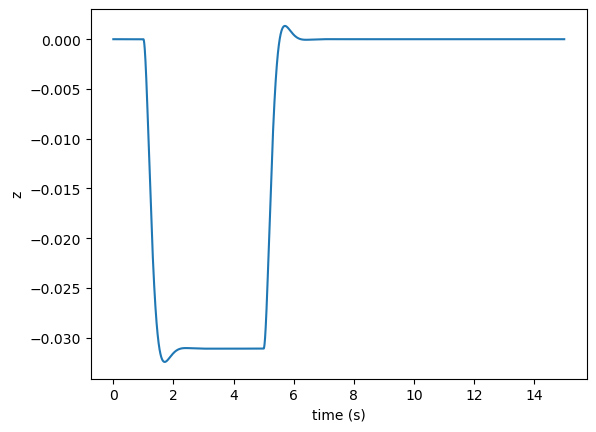

In [119]:
plt.plot(T, sol[:,0])
plt.xlabel('time (s)')
plt.ylabel('z')

Text(0, 0.5, 'phi_dot')

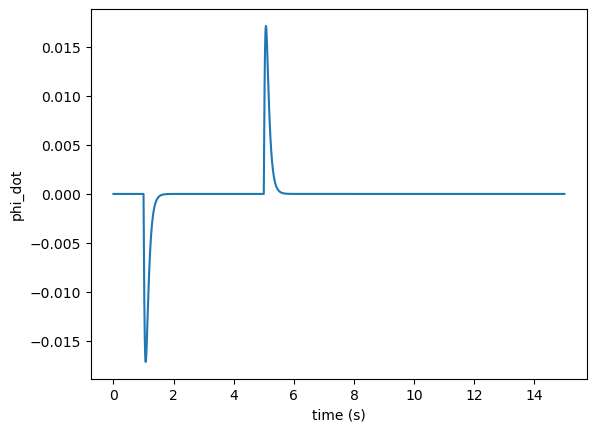

In [120]:
plt.plot(T, sol[:,4])
plt.xlabel('time (s)')
plt.ylabel('phi_dot')

Text(0, 0.5, 'theta_dot')

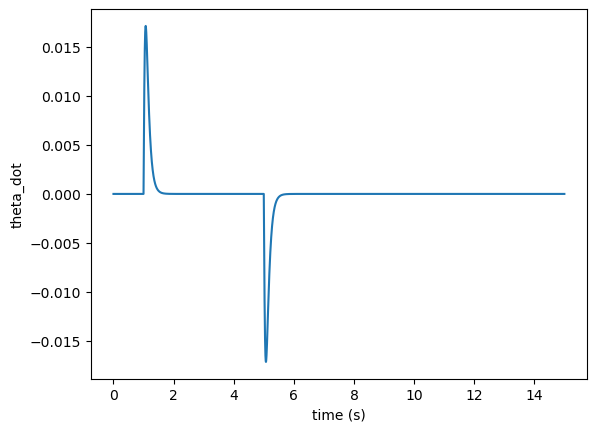

In [121]:
plt.plot(T, sol[:,5])
plt.xlabel('time (s)')
plt.ylabel('theta_dot')